# Media Analyser - By Gabriel Hanich

In [1]:
# Imports
import json
from collections import Counter
import matplotlib.pyplot as plt
from datetime import date, datetime
import datetime as dt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import pr

import sys
sys.path.append('../') # Allows importing of local modules

from lib.data import getData
from lib.media import outlet, article

In [2]:
# Constants
dataVersion = 1
stopwords = stopwords.words("english")

In [3]:
def daterange(date1, date2): # Returns list of dates between 2 dates
    for n in range(int((date2 - date1).days)+1):
        yield date1 + dt.timedelta(n)

In [4]:
with open("../Media Outlets.csv") as outletsFile: # Get list of outlets
    outletsData = getData(outletsFile)

outlets = []
for thisOutlet in outletsData:
    outlets.append(outlet(thisOutlet[0]))

    with open("../data/" + str(dataVersion) + "/json/" + thisOutlet[0] + ".json", encoding="utf-8") as dataFile:
        outlets[-1].setDayDict(json.load(dataFile)) # Write daydict to outlet Object

In [5]:
def getXYVals(outlet, statType, startDate, endDate, titleSearchWords, commonWordCount):
    # Returns a list containing the x, y and z (annotation) for a given media outlet
    xVals = []
    yVals = []
    zVals = []
    for myDate in list(daterange(startDate, endDate)): # For every date between the given start and end date
        try:
            articleCount = 0
            avgSentiment = 0
            commonWords = []
            totalWords = []
            for articleIndex, article in enumerate(outlet.dayDict[myDate.strftime("%d/%m/%Y")]):
                # If there are no title search words OR title contains wanted word
                if titleSearchWords == [] or set(titleSearchWords).intersection(word_tokenize(article["headline"].lower())):
                    articleCount += 1
                    avgSentiment += article["intensityScore"]
                    for word in word_tokenize(article["headline"]):
                        if len(word) > 2:
                            if word not in stopwords:
                                totalWords.append(str(word))

            commonWords = Counter(totalWords).most_common(commonWordCount)
            # Append data depending on chosen chart type        
            if statType == "articleCount":
                yVals.append(articleCount)
            elif statType == "avgSentiment":
                try:
                    yVals.append(avgSentiment / articleCount)
                except ZeroDivisionError:
                    yVals.append(0)
            elif statType  == "commonWords":
                yVals.append(articleCount)
                zVals.append(commonWords)

            xVals.append(myDate)
        except KeyError: # In case outlet has no articles published on that date (Returns empty lists)
            pass
    return xVals, yVals, zVals

In [7]:
# User settings
startingDate = "13/9/2021"
endDate = "9/1/2022"

doSetDates = True # Whether to use user-specified dates
doSetOutlets = False # Whether to limit search to a set of outlets
commonWordCount = 1 # How many common words per day are displayed
titleSearchWords = [] # Only include articles with headlines containing these words (Leave BLANK to disable)
setOutlets = ["ABC News"] # Only include a set of outlets
chartType = "articleCount"

In [8]:
if doSetOutlets:
    # Trim down outlet list to only include those chosen
    newOutlets = []
    for outlet in outlets:
        if outlet.name in setOutlets:
            newOutlets.append(outlet)
    outlets = newOutlets

startingDate = datetime.strptime(startingDate, "%d/%m/%Y")
endDate = datetime.strptime(endDate, "%d/%m/%Y")

<IPython.core.display.Javascript object>


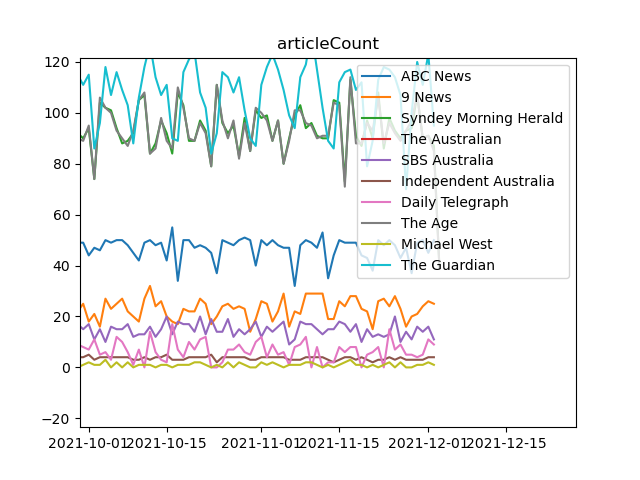

In [9]:
# Plot data 
fig, ax = plt.subplots(1)
ax.set_title(chartType)

for mediaOutlet in outlets:
    try:
        if not doSetDates:
            startingDate = list(mediaOutlet.dayDict.keys())[0] # Get date of first article
            endDate = list(mediaOutlet.dayDict.keys())[-1] # Get date of last article

            startingDate = datetime.strptime(startingDate, "%d/%m/%Y")
            endDate = datetime.strptime(endDate, "%d/%m/%Y")

    except IndexError:
        continue

    xVals, yVals, zVals = getXYVals(mediaOutlet, chartType, startingDate, endDate, titleSearchWords, commonWordCount)

    ax.plot(xVals, yVals, label=mediaOutlet.name)   
    
    if len(zVals) != 0: # If there are annotations present
        for dayIndex, dayPoint in enumerate(zVals):
            for i in range(len(dayPoint)):
                ax.annotate(dayPoint[i][0], (xVals[dayIndex], yVals[dayIndex] - i))


<IPython.core.display.Javascript object>


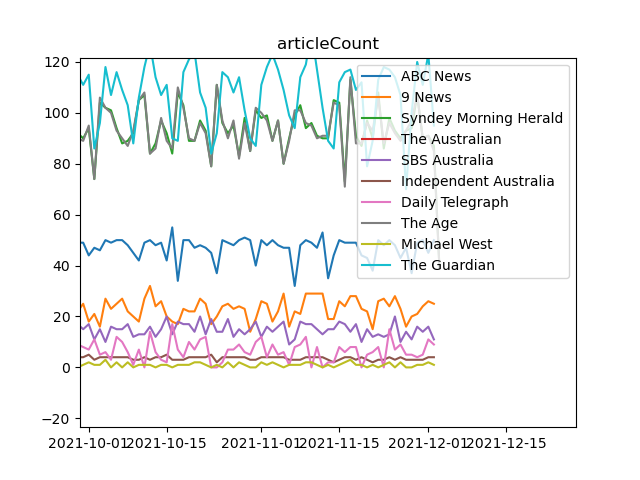

In [11]:
# Display plot
ax.legend()
fig